In [1]:
import pandas as pd
import numpy as np
import sys
import operator
from scipy import stats
import requests
from IPython.display import HTML
import matplotlib.pylab as plt
import warnings
import geopandas as gpd
from fiona.crs import from_epsg

import statsmodels.formula.api as smf

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 1. energy consumption data

In [2]:
# Read data
df_xls = pd.read_excel(r'http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx')

# Convert to .csv
df_xls.to_csv(r'..\data\nyc_benchmarking_disclosure_data_reported_in_2016.csv', encoding='utf-8')
df = pd.read_csv(r'..\data\nyc_benchmarking_disclosure_data_reported_in_2016.csv')

In [3]:
del df['Unnamed: 0']
# This transformation is in case your system doesn't recognize the current encoding
cols = df.columns.str.replace('\xc2\xb2', '_2')
df.columns = cols

In [4]:
# consider only Multifamily Housing
df = df[df['Primary Property Type - Self Selected'] == 'Multifamily Housing']

In [5]:
# Drop nans
df = df.dropna(subset=['Site EUI (kBtu/ft²)'])
print ('Examples after dropping NaNs:', len(df))
# Drop zero EUI values
df = df[df['Site EUI (kBtu/ft²)']>0]
print ('Examples after dropping zeros:', len(df))
df = df[df['Zip Code'].notnull()]
df['Zip Code'] = df['Zip Code'].astype(int)

Examples after dropping NaNs: 8654
Examples after dropping zeros: 8652


In [6]:
# Takes the logarithm of EUI and filters out examples that fall outside the threshold of two standard deviations.
def clean(df):   
    df = df[(df.log_eui<np.mean(df.log_eui)+2*np.std(df.log_eui))&(df.log_eui>np.mean(df.log_eui)-2*np.std(df.log_eui))]
    return df
df['eui'] = df['Site EUI (kBtu/ft²)']
df['log_eui'] = np.log10(df.eui)
df['nrg'] = df['Property GFA - Self-reported (ft²)'] * df['eui']
df = clean(df)

In [7]:
df.eui.describe()

count    8165.000000
mean       85.998922
std        28.983410
min        20.800000
25%        68.700000
50%        82.800000
75%        99.900000
max       304.800000
Name: eui, dtype: float64

In [8]:
# calculate normalized energy consumption and CO2 emission
data_avg = df.groupby('Zip Code').sum()
data_avg.reset_index(inplace=True) 
data_avg['energy'] = data_avg['nrg'] / data_avg['Property GFA - Self-reported (ft²)']
data_avg['emission'] = data_avg['Total GHG Emissions (Metric Tons CO2e)'] / data_avg['Property GFA - Self-reported (ft²)'] * 1000
#data_avg['ZIP Code'] = data_avg.index.values
data_avg.rename(columns = { u'Zip Code' : 'ZIP Code'}, inplace=True)
data_avg = data_avg.loc[:, [ 'energy', 'emission', 'ZIP Code']]
data_avg.head()

,energy,emission,ZIP Code
0,81.349229,5.476616,10001
1,120.714535,8.243644,10002
2,86.029293,5.916308,10003
3,101.879554,7.511470,10004
4,85.379882,5.963690,10005


## 2. asthma hospitalization data

In [9]:
# read asthma hospitalization data (three year average 2012-2014)
asthma_rate = pd.read_csv("Asthma_Rate.csv")

In [10]:
for col in range(len(asthma_rate.columns)):
    asthma_rate.iloc[:, col] = pd.to_numeric(asthma_rate.iloc[:, col], errors='coerce').astype(float)

In [11]:
asthma_rate = asthma_rate.dropna()
asthma_rate['ZIP Code'] = asthma_rate['ZIP Code'].astype(int)
asthma_rate.to_csv("asthma.csv")

In [12]:
# Takes out outliners fall outside the threshold of two standard deviations.
asthma_rate = asthma_rate[(asthma_rate.Rate<np.mean(asthma_rate.Rate)+ \
                           2*np.std(asthma_rate.Rate))&(asthma_rate.Rate>np.mean(asthma_rate.Rate)-2*np.std(asthma_rate.Rate))]
asthma_rate.rename(columns = { u'Rate' : 'asthma_rate'}, inplace=True)
asthma_rate.head()

,ZIP Code,2012-2014,asthma_rate
0,10001,159.0,21.9
1,10002,592.0,23.9
2,10003,130.0,7.7
6,10007,14.0,2.9
7,10009,534.0,28.3


## 3. income data

In [13]:
# Download income information from IRS for NYC and extract the income per person by zipcode 
income = pd.read_excel("http://www.nber.org/tax-stats/zipcode/2014/14zp33ny.xls", skiprows=3).iloc[10::8, [0,1,2,4,8,12]]
income.reset_index(inplace=True)
income.rename(columns = { u'ZIP code [1]' : 'ZIP Code'}, inplace=True)

In [14]:
income["pop"] = (income["Number of dependents"] + income["Number of joint returns"] + income["Number of returns"])
income["income_avg"] = (income["Adjusted gross income (AGI) [3]"] / income["pop"])
income.rename(columns = { u'ZIP\ncode [1]' : 'ZIP Code'}, inplace=True)
income.drop(["Size of adjusted gross income", "index" ,"Number of returns", \
             "Number of joint returns", "Number of dependents", "Adjusted gross income (AGI) [3]"], 
                 axis=1, inplace=True)

In [15]:
income = income[(income.income_avg<np.mean(income.income_avg)+ \
                           2*np.std(income.income_avg))&(income.income_avg>np.mean(income.income_avg)-2*np.std(income.income_avg))]
income.reset_index(inplace=True) 
income.head()

,index,ZIP Code,pop,income_avg
0,0,10001,19740.0,119.754813
1,1,10002,73570.0,30.114748
2,7,10009,47930.0,53.838306
3,21,10025,76150.0,90.321930
4,22,10026,30910.0,35.908476


## 4.merge theh data

In [16]:
df_ = pd.merge(asthma_rate, data_avg, on='ZIP Code', how='inner') 
df_ = pd.merge(df_, income, on='ZIP Code', how='inner')

In [17]:
df_.drop(['2012-2014', 'index', 'pop'], axis=1, inplace=True)
df_.head()

,ZIP Code,asthma_rate,energy,emission,income_avg
0,10001,21.9,81.349229,5.476616,119.754813
1,10002,23.9,120.714535,8.243644,30.114748
2,10009,28.3,81.675465,5.338008,53.838306
3,10025,20.2,76.108038,5.215263,90.321930
4,10026,38.6,82.427287,5.579166,35.908476


In [18]:
df_.describe()

,ZIP Code,asthma_rate,energy,emission,income_avg
count,113.000000,113.000000,113.000000,113.000000,113.000000
mean,11003.699115,20.570796,85.718789,5.416203,32.540705
std,510.216934,9.648230,20.283510,1.219560,18.266038
min,10001.000000,6.000000,22.900000,1.899392,12.645639
25%,10469.000000,12.600000,76.168138,4.709151,21.994217
50%,11222.000000,18.800000,85.053691,5.266992,28.677517
75%,11369.000000,28.000000,95.266712,6.023112,34.462120
max,11694.000000,43.700000,173.041379,10.788226,119.754813


In [19]:
df_.corr()

,ZIP Code,asthma_rate,energy,emission,income_avg
ZIP Code,1.000000,-0.362125,-0.030652,-0.153935,-0.230602
asthma_rate,-0.362125,1.000000,0.159430,0.155115,-0.164774
energy,-0.030652,0.159430,1.000000,0.958649,-0.159793
emission,-0.153935,0.155115,0.958649,1.000000,-0.105661
income_avg,-0.230602,-0.164774,-0.159793,-0.105661,1.000000


## 5. analysis

### asthma vs GHG intensity

a.linear model

In [20]:
lm1 = smf.ols(formula='asthma_rate ~ emission', data = df_).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            asthma_rate   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.737
Date:                Tue, 14 Nov 2017   Prob (F-statistic):              0.101
Time:                        07:07:37   Log-Likelihood:                -414.61
No. Observations:                 113   AIC:                             833.2
Df Residuals:                     111   BIC:                             838.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     13.9243      4.118      3.382      0.001         5.765    22.083
emission       1.2272      0.742      1.654      0.101        -0.243     2.697
==============================================================================
Omnibus:                        7.884   Durbin-Watson:                   1.244
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.504
Skew:                           0.571   Prob(JB):                       0.0235
Kurtosis:                       2.462   Cond. No.                         26.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

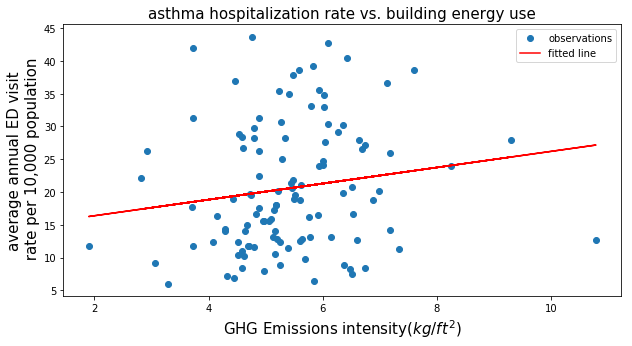

In [21]:
# Visualize the data set
plt.figure(figsize=(10,5))
plt.plot(df_['emission'], df_['asthma_rate'], 'o', label = 'observations')
plt.xlabel('GHG Emissions intensity$(kg/ft^2)$', fontsize = 15)
plt.ylabel('average annual ED visit\n rate per 10,000 population', fontsize = 15)
plt.plot(df_['emission'], lm1.predict(), '-r', label = 'fitted line')
plt.title('asthma hospitalization rate vs. building energy use', fontsize = 15)
plt.legend()
plt.show()

b. log-log scale model

In [22]:
df_['log_emission'] = np.log10(df_['emission'])
df_['log_rate'] = np.log10(df_['asthma_rate'])

In [23]:
lm2 = smf.ols(formula='log_rate ~ log_emission', data = df_).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rate   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     3.829
Date:                Tue, 14 Nov 2017   Prob (F-statistic):             0.0529
Time:                        07:07:37   Log-Likelihood:                 16.632
No. Observations:                 113   AIC:                            -29.26
Df Residuals:                     111   BIC:                            -23.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.9851      0.144      6.853      0.000         0.700     1.270
log_emission     0.3855      0.197      1.957      0.053        -0.005     0.776
==============================================================================
Omnibus:                        6.501   Durbin-Watson:                   1.239
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                3.346
Skew:                          -0.175   Prob(JB):                        0.188
Kurtosis:                       2.233   Cond. No.                         15.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

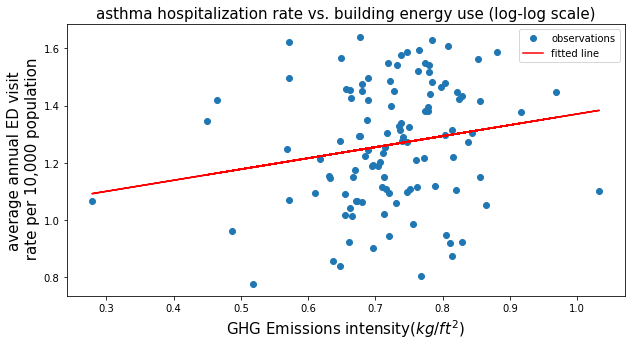

In [24]:
plt.figure(figsize=(10,5))
plt.plot(df_['log_emission'] , df_['log_rate'], 'o', label = 'observations')
plt.xlabel('GHG Emissions intensity$(kg/ft^2)$', fontsize = 15)
plt.ylabel('average annual ED visit\n rate per 10,000 population', fontsize = 15)
plt.plot(df_['log_emission'], lm2.predict(), '-r', label = 'fitted line')
plt.title('asthma hospitalization rate vs. building energy use (log-log scale)', fontsize = 15)
plt.legend()

c. 2nd degree polynomial model

In [25]:
curvemodel = smf.ols(formula='log_rate ~ log_emission + I(log_emission ** 2)', data = df_).fit()
curvemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rate   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.948
Date:                Tue, 14 Nov 2017   Prob (F-statistic):              0.148
Time:                        07:07:38   Log-Likelihood:                 16.682
No. Observations:                 113   AIC:                            -27.36
Df Residuals:                     110   BIC:                            -19.18
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                0.8577      0.433      1.982      0.050      5.97e-05     1.715
log_emission             0.7672      1.238      0.620      0.537        -1.686     3.221
I(log_emission ** 2)    -0.2788      0.893     -0.312      0.755        -2.048     1.491
==============================================================================
Omnibus:                        6.741   Durbin-Watson:                   1.228
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                3.411
Skew:                          -0.176   Prob(JB):                        0.182
Kurtosis:                       2.225   Cond. No.                         107.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

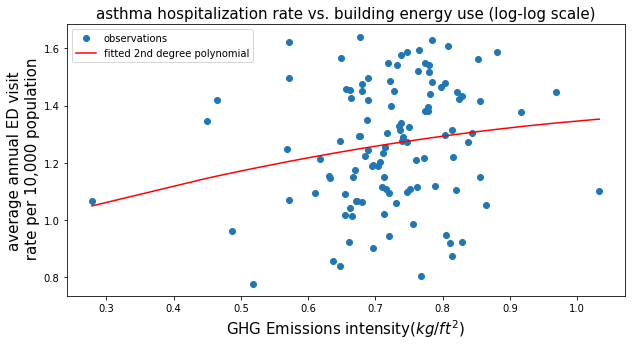

In [26]:
plt.figure(figsize=(10,5))
plt.plot(df_['log_emission'] , df_['log_rate'], 'o', label = 'observations')
plt.xlabel('GHG Emissions intensity$(kg/ft^2)$', fontsize = 15)
plt.ylabel('average annual ED visit\n rate per 10,000 population', fontsize = 15)
plt.plot(df_['log_emission'].sort_values(), curvemodel.fittedvalues.sort_values(), '-r', label = 'fitted 2nd degree polynomial')
plt.title('asthma hospitalization rate vs. building energy use (log-log scale)', fontsize = 15)
plt.legend()

### energy consumption vs. income

a.linear model

In [27]:
lm3 = smf.ols(formula='energy ~ income_avg', data = df_).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.909
Date:                Tue, 14 Nov 2017   Prob (F-statistic):             0.0909
Time:                        07:07:38   Log-Likelihood:                -498.48
No. Observations:                 113   AIC:                             1001.
Df Residuals:                     111   BIC:                             1006.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     91.4929      3.879     23.590      0.000        83.807    99.178
income_avg    -0.1774      0.104     -1.705      0.091        -0.384     0.029
==============================================================================
Omnibus:                       36.620   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.889
Skew:                           0.967   Prob(JB):                     1.16e-35
Kurtosis:                       8.516   Cond. No.                         76.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

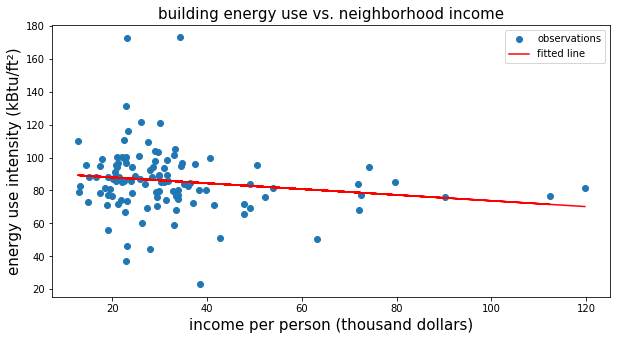

In [28]:
# Visualize the data set
plt.figure(figsize=(10,5))
plt.plot(df_['income_avg'], df_['energy'], 'o', label = 'observations')
plt.xlabel('income per person (thousand dollars)', fontsize = 15)
plt.ylabel('energy use intensity (kBtu/ft²)', fontsize = 15)
plt.plot(df_['income_avg'], lm3.predict(), '-r', label = 'fitted line')
plt.title('building energy use vs. neighborhood income', fontsize = 15)
plt.legend()

b. log-log scale model

In [29]:
df_['log_energy'] = np.log10(df_['energy'])
df_['log_income'] = np.log10(df_['income_avg'])

In [30]:
lm4 = smf.ols(formula='log_energy ~ log_income', data = df_).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_energy   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.977
Date:                Tue, 14 Nov 2017   Prob (F-statistic):             0.0872
Time:                        07:07:38   Log-Likelihood:                 91.377
No. Observations:                 113   AIC:                            -178.8
Df Residuals:                     111   BIC:                            -173.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.0578      0.080     25.632      0.000         1.899     2.217
log_income    -0.0937      0.054     -1.725      0.087        -0.201     0.014
==============================================================================
Omnibus:                       49.008   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.326
Skew:                          -1.339   Prob(JB):                     1.45e-53
Kurtosis:                       9.671   Cond. No.                         16.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

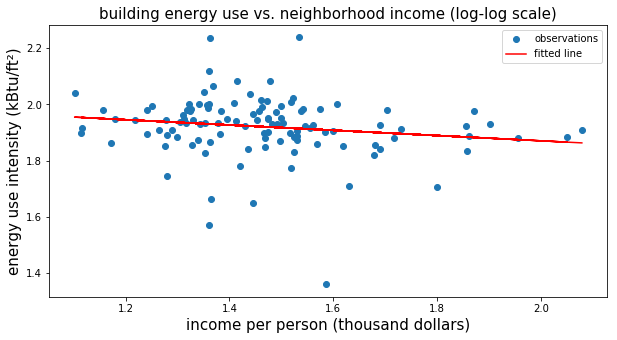

In [31]:
plt.figure(figsize=(10,5))
plt.plot(df_['log_income'] , df_['log_energy'], 'o', label = 'observations')
plt.xlabel('income per person (thousand dollars)', fontsize = 15)
plt.ylabel('energy use intensity (kBtu/ft²)', fontsize = 15)
plt.plot(df_['log_income'], lm4.predict(), '-r', label = 'fitted line')
plt.title('building energy use vs. neighborhood income (log-log scale)', fontsize = 15)
plt.legend()

c. 2nd degree polynomial model

In [32]:
curvemodel2 = smf.ols(formula='log_energy  ~ log_income + I(log_income ** 2)', data = df_).fit()
curvemodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_energy   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.479
Date:                Tue, 14 Nov 2017   Prob (F-statistic):              0.232
Time:                        07:07:39   Log-Likelihood:                 91.380
No. Observations:                 113   AIC:                            -176.8
Df Residuals:                     110   BIC:                            -168.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              2.0961      0.457      4.591      0.000         1.191     3.001
log_income            -0.1440      0.593     -0.243      0.809        -1.319     1.031
I(log_income ** 2)     0.0162      0.191      0.085      0.932        -0.361     0.394
==============================================================================
Omnibus:                       48.734   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.411
Skew:                          -1.331   Prob(JB):                     3.79e-53
Kurtosis:                       9.648   Cond. No.                         215.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

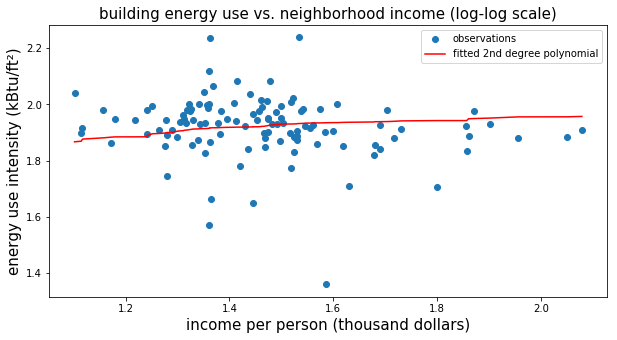

In [33]:
plt.figure(figsize=(10,5))
plt.plot(df_['log_income'] , df_['log_energy'], 'o', label = 'observations')
plt.xlabel('income per person (thousand dollars)', fontsize = 15)
plt.ylabel('energy use intensity (kBtu/ft²)', fontsize = 15)
plt.plot(df_['log_income'].sort_values(), curvemodel2.fittedvalues.sort_values(), '-r', label = 'fitted 2nd degree polynomial')
plt.title('building energy use vs. neighborhood income (log-log scale)', fontsize = 15)
plt.legend()

## 6. visualization

In [34]:
nyshp = gpd.read_file('NY.shp')

In [35]:
nyshp.head()

,zipcode,geometry
0,11372.0,POLYGON Z ((-73.86942457284175 40.749156870967...
1,11004.0,POLYGON Z ((-73.71068374074007 40.750040394509...
2,11040.0,POLYGON Z ((-73.70098278625547 40.738895699230...
3,11426.0,POLYGON Z ((-73.72270447144122 40.753733714383...
4,11365.0,POLYGON Z ((-73.81088634744755 40.727171875759...


Text(0.5,1,'asthma hospitalization rate')

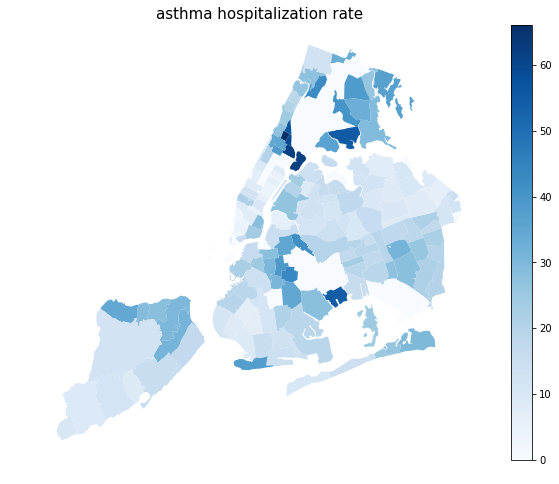

In [36]:
asthma = pd.read_csv("asthma.csv")
nyshp1 = nyshp.merge(asthma,left_on='zipcode',right_on='ZIP Code',how='outer')
nyshp1['Rate'] = nyshp1['Rate'].fillna(0)
fig, ax = plt.subplots(figsize=(10,8))
nyshp1.plot(column='Rate', cmap='Blues',ax=ax,legend=True)
ax.set_axis_off()
ax.legend()
ax.set_title('asthma hospitalization rate',size=15)

Text(0.5,1,'income per capita')

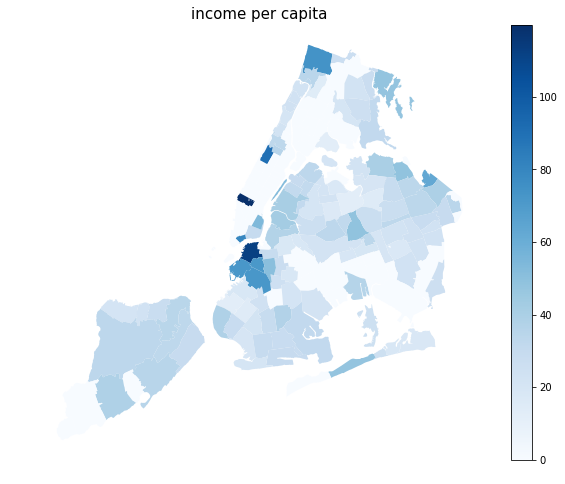

In [37]:
nyshp2 = nyshp.merge(df_,left_on='zipcode',right_on='ZIP Code',how='outer')
nyshp2['income_avg'] = nyshp2['income_avg'].fillna(0)
fig, ax = plt.subplots(figsize=(10,8))
nyshp2.plot(column='income_avg', cmap='Blues',ax=ax,legend=True)
ax.set_axis_off()
ax.legend()
ax.set_title('income per capita',size=15)

Text(0.5,1,'energy use intensity')

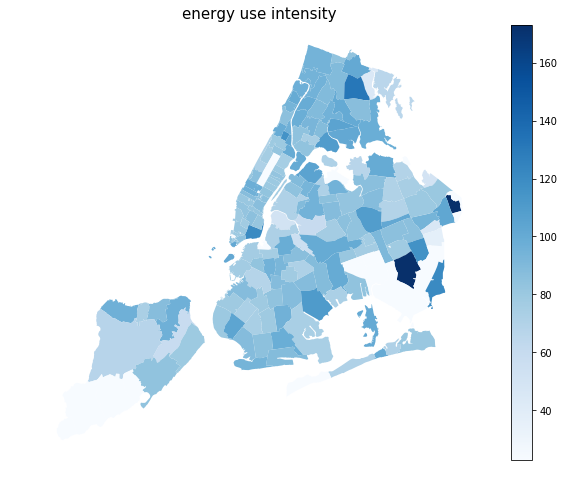

In [38]:
nyshp3 = nyshp.merge(data_avg,left_on='zipcode',right_on='ZIP Code',how='outer')
#nyshp['energy'] = nyshp['energy'].fillna(0)
fig, ax = plt.subplots(figsize=(10,8))
nyshp3.plot(column='energy', cmap='Blues',ax=ax,legend=True)
ax.set_axis_off()
ax.legend()
ax.set_title('energy use intensity',size=15)

Text(0.5,1,'GHG emission intensity')

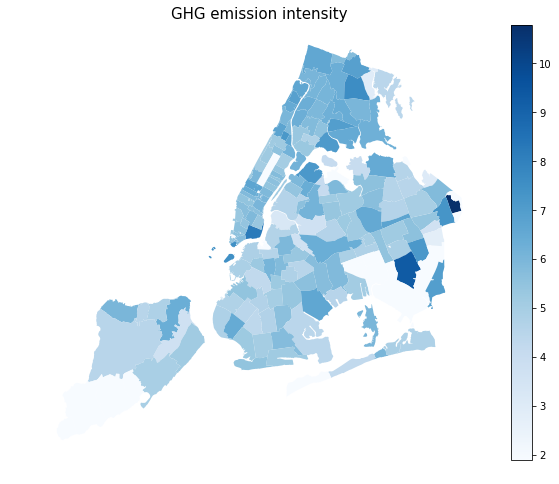

In [39]:
#nyshp['energy'] = nyshp['energy'].fillna(0)
fig, ax = plt.subplots(figsize=(10,8))
nyshp3.plot(column='emission', cmap='Blues',ax=ax,legend=True)
ax.set_axis_off()
ax.legend()
ax.set_title('GHG emission intensity',size=15)